In [1]:
import jax.numpy as jnp
from sklearn.neighbors import KernelDensity
import numpy as np
from chainconsumer import ChainConsumer
# from sbi_lens.config import config_lsst_y_10

In [2]:
sample_ff = jnp.load(
    "/linkhome/rech/genkqu01/ufa23yn/sbi_lens/sbi_lens/data/posterior_full_field__256N_10ms_27gpa_0.26se.npy"
)

2024-05-08 22:10:38.777249: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfslocalsup/spack_soft/sox/14.4.2/gcc-8.4.1-egb3ni235l3f4q4lxbo3gfqgws6fdecl/lib:/gpfslocalsup/spack_soft/openmpi/4.1.1/gcc-8.5.0-mbafzinnzpvx22cqojowmnmatg2po2aw/lib:/gpfslocalsup/spack_soft/cudnn/8.1.1.33-11.2/gcc-8.3.1-dgsfwc7e23vzc36jopc5nxyunptm2ieh/lib64:/gpfslocalsup/spack_soft/nccl/2.9.6-1/gcc-8.3.1-2c3rwcolksekujszxrg7r72uxmekxx2y/lib:/gpfslocalsys/cuda/11.2/nvvm/lib64:/gpfslocalsys/cuda/11.2/extras/CUPTI/lib64:/gpfslocalsys/cuda/11.2/lib64:/gpfslocalsys/cuda/11.2/samples/common/lib/linux/x86_64:/gpfslocalsys/cuda/11.2/targets/x86_64-linux/lib:/gpfslocalsys/slurm/current/lib/slurm:/gpfslocalsys/slurm/current/lib:/gpfslocalsys/slurm/current/lib/slurm:/gpfslocalsys/slurm/current/lib
2024-05-08 22:10:38.777286: W external/org_tensor

In [3]:
simu_budget = jnp.array([200, 500, 1000, 1500, 2000, 3000, 5000, 10_000, 20_000, 50_000, 100_000,  150_000]) #* 63

In [4]:
number_chains = 31
chains = []
for i in range(number_chains):
    posterior = jnp.load(
    '/gpfsdswork/projects/rech/eqw/ufa23yn/dev/lensing_project/paper_sbi_lensing/hmc_becnhmarck/posterior_full_field_job_{}N_256ms_10gpa_27se.npy'.format(i),
    allow_pickle=True
    )
    chains.append(posterior)
    
chains = jnp.array(chains).reshape([-1,6])

In [5]:
from sbi_lens.config import config_lsst_y_10

params_name = config_lsst_y_10.params_name_latex
truth = config_lsst_y_10.truth

In [6]:
# plot params
# import arviz 
# az.style.use("arviz-white")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["lines.linewidth"] = 1
plt.rcParams['lines.markersize'] = 3
color = [
   '#f8c471',
    '#d68910',
    '#cd6155',
    '#edbb99',
    '#5d6d7e',
    '#73c6b6',
    '#a3b899'
]

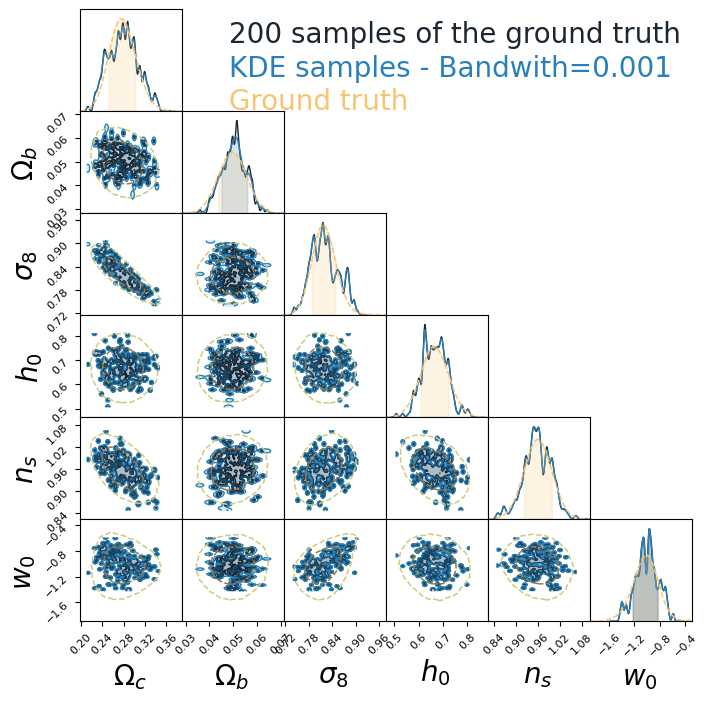

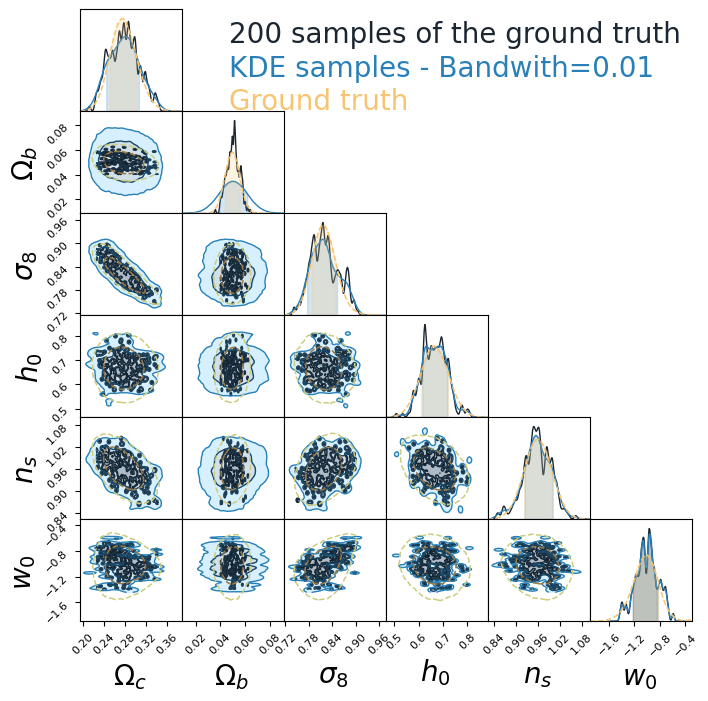

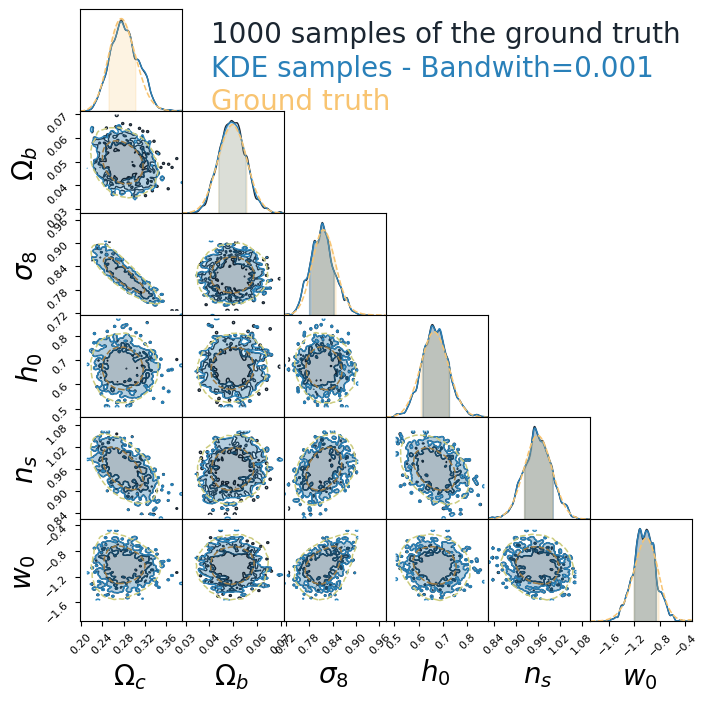

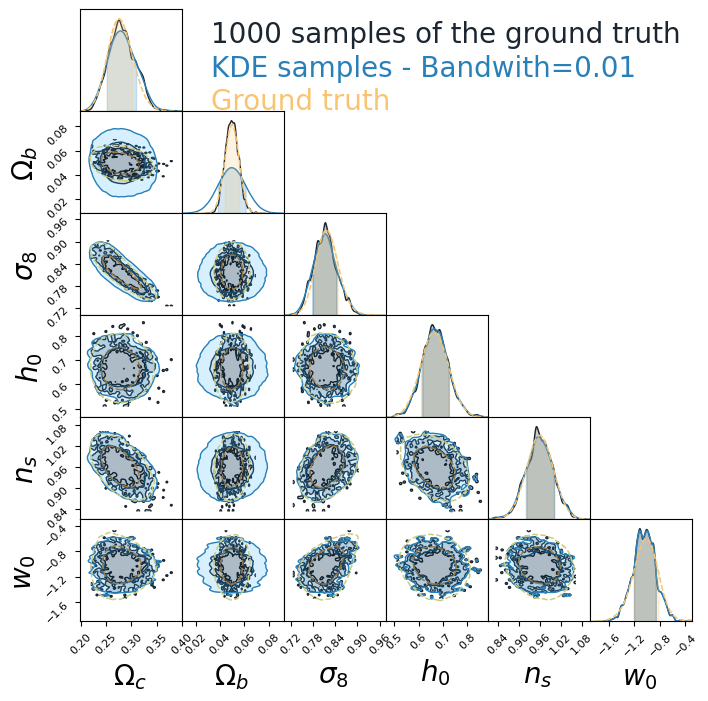

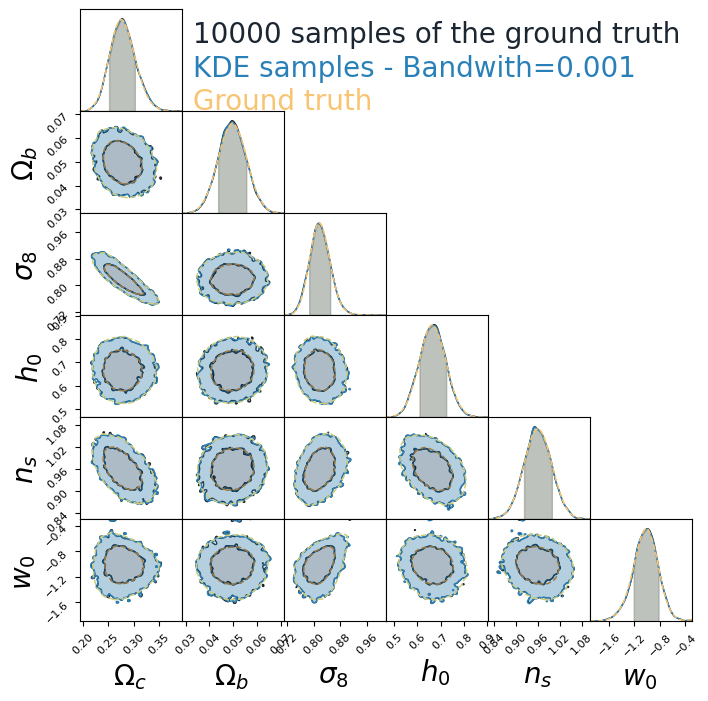

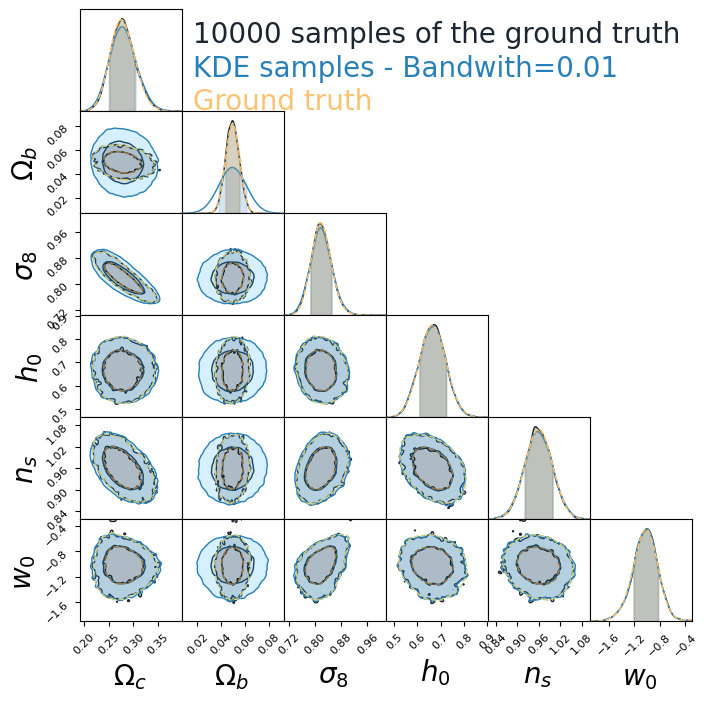

In [19]:
# lets find the correct bandwidth 
# bandwidth = jnp.sqrt(len(sample_ff))/10


# nb_sample = 10000
# bandwidth = 1e-2

for nb_sample in [200, 1000, 10000]:
    for bandwith in [1e-3, 1e-2]:
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(sample_ff[:nb_sample])
        kde_sample = kde.sample(len(sample_ff))
        
        c = ChainConsumer()
        c.add_chain(
            sample_ff[:nb_sample],
            name=f'{nb_sample} samples of the ground truth',
            linewidth=1.,
            color = '#1B2631',
            shade_alpha = 0.2, 
            parameters = params_name, 
            shade=True
        )
        c.add_chain(
            kde_sample,
            name='KDE samples - Bandwith={}'.format(float(bandwith)),
            linewidth=1.,
            color = '#2980B9',
            shade_alpha = 0.2,
            # linestyle = '--',
            parameters = params_name, 
            shade = True
        )
        c.add_chain(
                sample_ff,
                parameters=params_name,
                name='Ground truth',
                linewidth=1.1,
                color = color[0],
                shade_alpha = 0.3, 
                shade = False, 
                linestyle = '--'
        )
        c.configure(legend_kwargs={"fontsize": 20}, tick_font_size=8, label_font_size=20)#, smooth=1)
        fig = c.plotter.plot(
            figsize=0.8, 
            # extents=[[t - 4 * np.std(sample_ff[:,i]),
            #           t + 4 * np.std(sample_ff[:,i])] for i,t in enumerate(truth)]
        )
        plt.savefig(f'proof_kde_{nb_sample}_{bandwith}.pdf', transparent = True)

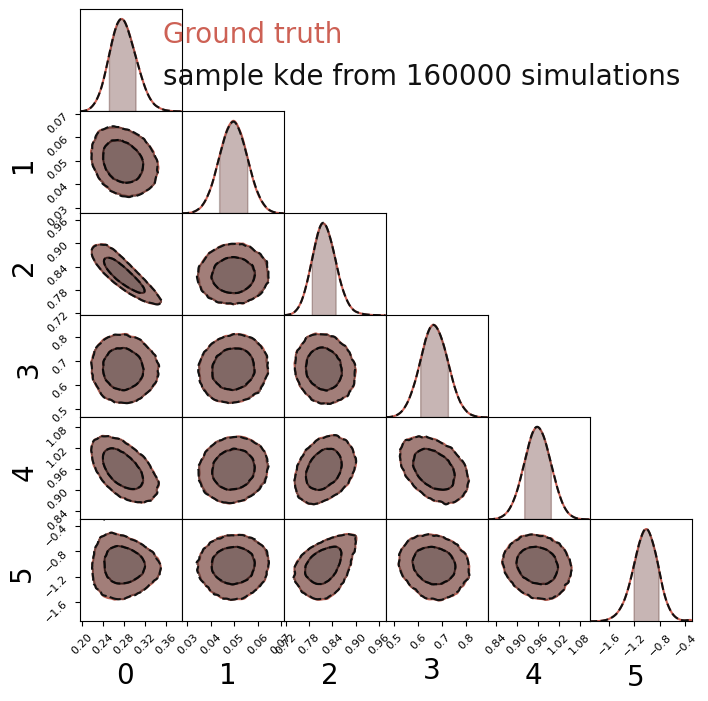

In [10]:
# lets find the correct bandwidth 

kde = KernelDensity(kernel='gaussian', bandwidth=1e-3).fit(sample_ff)
kde_sample = kde.sample(len(sample_ff))

c = ChainConsumer()
c.add_chain(
    sample_ff,
    name='Ground truth',
    linewidth=1.5,
    color = "#CD6155",
    shade_alpha = 0.5
)

c.add_chain(
    kde_sample,
    name='sample kde from {} simulations'.format(len(sample_ff)),
    linewidth=1.5,
    color = "#111111",
    shade_alpha = 0.4,
    linestyle = '--'
)

c.configure(legend_kwargs={"fontsize": 20}, tick_font_size=8, label_font_size=20)
fig = c.plotter.plot(
    figsize=0.8
)

In [ ]:
from sbi_lens.metrics.c2st import c2st
simu_budget = jnp.array([200, 500, 1000, 1500, 2000, 3000, 5000, 10_000, 20_000, 50_000, 100_000, 150_000])
c2st_store = []
for i in simu_budget:
    X = chains[:i, :]
    print(X.shape)
    kde = KernelDensity(kernel='gaussian', bandwidth=1e-3).fit(X)
    kde_sample = kde.sample(len(sample_ff))
    
    inds = np.random.randint(0, len(sample_ff), 10_000)
    c2st_metric = c2st(
        sample_ff[inds], kde_sample[inds], seed=0, n_folds=5
    )
    
    c2st_store.append(c2st_metric)

    c = ChainConsumer()
    c.add_chain(
        sample_ff,
        name='Ground truth',
        linewidth=1.5,
        color = "#CD6155",
        shade_alpha = 0.5
    )

    c.add_chain(
        kde_sample,
        name='hmc with {} simulations'.format(i),
        linewidth=1.5,
        color = "#111111",
        shade_alpha = 0.4,
    )

    c.configure(legend_kwargs={"fontsize": 20}, tick_font_size=8, label_font_size=20)
    fig = c.plotter.plot(
        figsize=0.8
    )
    
print(c2st_store)

In [54]:
import tensorflow_probability as tfp

ess_store = []
for i in simu_budget:
    X = chains[:i, :]
    ess = tfp.mcmc.effective_sample_size(
        X 
    )
    ess_store.append(ess)
    
ess_store = jnp.round(jnp.min(jnp.array(ess_store), axis = 1))


def forward(x):
    return np.interp(x, simu_budget, ess_store)


def inverse(x):
    return np.interp(x, ess_store, simu_budget)

/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/tensorflow_probability/python/__init__.py:70: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  warnings.warn(


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


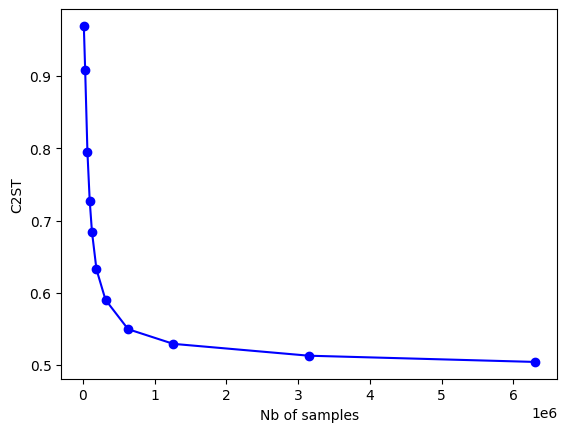

In [7]:
c2st_store = [0.9692,0.9077,0.7944,0.72765,0.6845,0.63235,0.5903,0.5497,0.5294,0.513,0.5044]
%pylab inline

fig, ax = plt.subplots()
ax.plot(simu_budget, c2st_store, c ='b')
ax.plot(simu_budget, c2st_store, 'o', c='b')
plt.xlabel('Nb of samples')
plt.ylabel('C2ST')
# secax = ax.secondary_xaxis('top', functions=(forward, inverse))
# secax.set_xlabel('Effective sample size')
plt.show()

In [16]:
jnp.save('convergence_hmc_results.npy', c2st_store)

In [13]:
jnp.save('convergence_hmc_results_ess.npy', ess_store)